In [1]:
%load_ext autoreload
%autoreload 2

import visualization
import studies
import deformation_graph
import numpy as np

In [2]:
out = visualization.video_set_up("original", fps=30, width=1920, height=1080)

DOWNSAMPLE = 2
TUMOR_PATH = "Pacients/BR074/Segment_1.stl"
ID = 74
RADIUS = 15
VOXEL_SIZE = 10

[ WARN:0@1.039] global /private/var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_11nitadzeg/croot/opencv-suite_1691620374638/work/modules/videoio/src/cap_gstreamer.cpp (2180) open OpenCV | GStreamer warning: cannot link elements
[ERROR:0@1.050] global /private/var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_11nitadzeg/croot/opencv-suite_1691620374638/work/modules/videoio/src/cap.cpp (597) open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_11nitadzeg/croot/opencv-suite_1691620374638/work/modules/videoio/src/cap_images.cpp:253: error: (-5:Bad argument) CAP_IMAGES: can't find starting number (in the name of file): original.avi in function 'icvExtractPattern'




In [3]:

pcd_scan, pcd_twin, pcd_tumor = studies.read_point_clouds(ID, scan_2=False)
_, _, transformation,_ = studies.first_transformation(pcd_twin, pcd_scan)
pcd_twin.paint_uniform_color([1, 0.706, 0])
pcd_scan.paint_uniform_color([0, 0.651, 0.929])
pcd_twin.transform(transformation)
pcd_tumor.transform(transformation)

[Open3D WARNING] Read geometry::Image failed: file extension bmp unknown
::       Rotation of the pcd
::      z_min and half_x: (-11.622517329961909, 8.284576282801751)
::      z_min and half_x: (0.0, 0.0)


PointCloud with 10000 points.

In [4]:



VG_TWIN, EG_TWIN = deformation_graph.graph_acquisition(pcd_twin, VOXEL_SIZE, RADIUS)
print("# Graph Points:", len(VG_TWIN))
print("# Edges:", len(EG_TWIN))
pcd_vg = visualization.visualize_graph(VG=VG_TWIN, EG=EG_TWIN, pcd_tumor=pcd_tumor, show_tumor=True, visualize_open3d=True)

Number of Initial Points for Graph acquisition 2297 with Downsample 10 and Radius 15
Average number of edges per node: 6.567685589519651
# Graph Points: 458
# Edges: 3008
[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display


In [5]:


graph_points = np.array(VG_TWIN)
source_points = np.asarray(pcd_twin.points)
target_points = np.array(pcd_scan.points)
tumor_points = np.array(pcd_tumor.points)

print(f"# Source points: {len(source_points)}")
print(f"# Target points: {len(target_points)}")
print(f"# Tumor points: {len(tumor_points)}")

# Source points: 388943
# Target points: 500000
# Tumor points: 10000


In [6]:
pcd_twin = pcd_twin.voxel_down_sample(voxel_size=2)
source_points = np.asarray(pcd_twin.points)
print(f"# Source points: {len(source_points)}")

# Source points: 49489


In [7]:
neighbors_dictionary = deformation_graph.find_neighbors(pcd_twin, pcd_vg, 20)
neighbors_tumor = deformation_graph.find_neighbors(pcd_tumor, pcd_vg, 150)
print("Neighbors acquired")

Average number of neighbors per point: 3.5685910000202066
Average number of neighbors per point: 185.0095
Neighbors acquired


In [8]:

max_iterations = 5000
alpha = 0.1
coeficient_weights_b = [1]  
coeficient_weights_a = [1/2]
epsilon = 0.001
lb = 0.0001

In [9]:

'''
Otimization using SGD:
Voxel Size of Source PointCloud & Step Size

2 & 0.0001
5 & 0.0005

'''
new_source_points, all_new_tumor_points, erros = deformation_graph.SGD_with_capture(source_points=source_points, graph_points=graph_points, target_points=target_points, tumor_points=tumor_points, 
                                                                       neighbors_source=neighbors_dictionary, neighbors_tumor= neighbors_tumor, 
                                                                       EG=EG_TWIN, 
                                                                       I_max=max_iterations, alpha=alpha, bs=coeficient_weights_b, ass=coeficient_weights_a, lb=lb, epsilon=epsilon, 
                                                                       out=out, capture= True)


[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display
Done F_tumor
Initialization Time: 45.883246183395386
Iteration 0, Total Error: 232208.57722309924, Align Error: 226958.36643448597, Reg Error: 5250.210788613279
Iteration 1, Total Error: 63721.54665674452, Align Error: 57857.48253821998, Reg Error: 5864.064118524534
Iteration 2, Total Error: 35236.77963396582, Align Error: 28519.237968422774, Reg Error: 6717.5416655430545
Iteration 3, Total Error: 24830.080083293524, Align Error: 17446.70766133474, Reg Error: 7383.372421958779
Iteration 4, Total Error: 20250.349569239123, Align Error: 12368.557753681578, Reg Error: 7881.791815557546
Iteration 5, Total Error: 17558.464229111836, Align Error: 9279.181343749959, Reg Error: 8279.282885361878
Iteration 6, Total Error: 15985.355681541547, Align Error: 7410.149797276864, Reg Error: 8575.205884264682
Iteration 7, Total Error: 14974.346241672754, Align Error: 6168.848729263955, Reg Error: 8805.4975124088
Iteration 8, To

In [10]:
visualization.plot_after_non_rigid_registration(new_source_points, all_new_tumor_points[0], pcd_tumor, pcd_scan, graph_points, EG_TWIN, pcd_twin, show_twin=True)


[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display


49437
46215


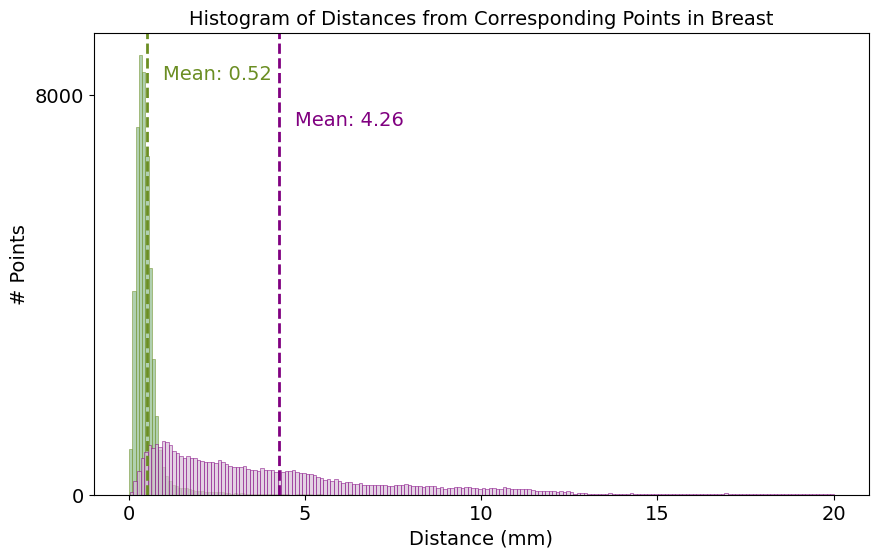

In [11]:
visualization.plot_histogram_distances_new_and_old(pcd_scan, new_source_points, pcd_twin, 14)

[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display
-14.9923585487008
14.987350217464723


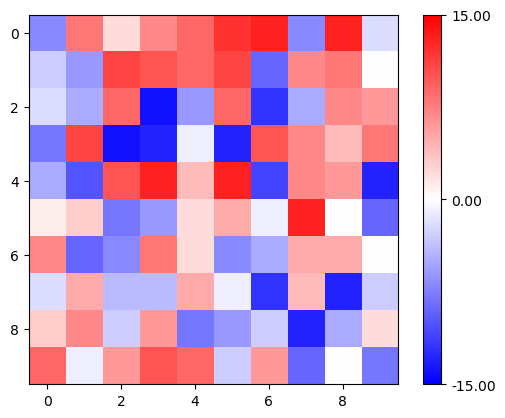

In [12]:
visualization.plot_red_blues_non_rigid_registration(s_points=new_source_points, t=pcd_scan, original=pcd_twin)

In [13]:
visualization.plot_tumor(pcd_tumor, all_new_tumor_points, coeficient_weights_b)

b = 1 have the color Red
[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display


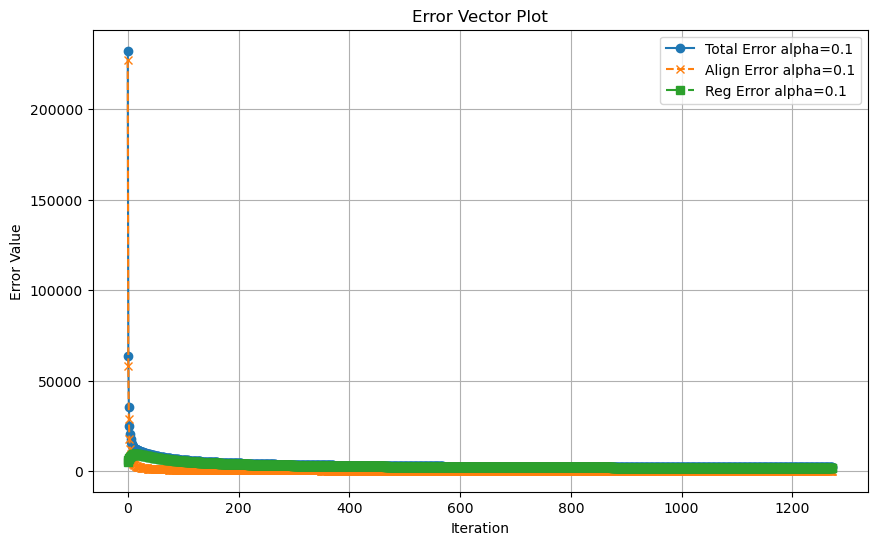

In [14]:
visualization.plot_errors(erros, alpha)

[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display


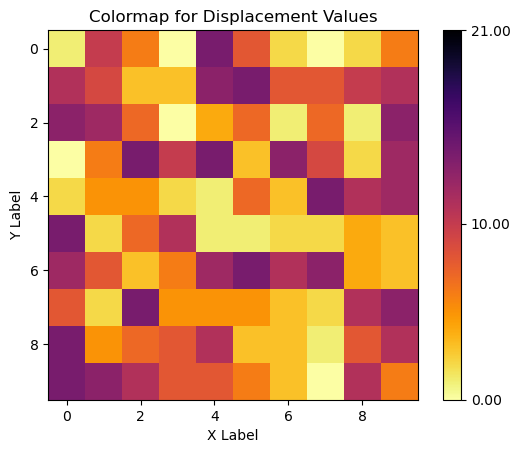

[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display


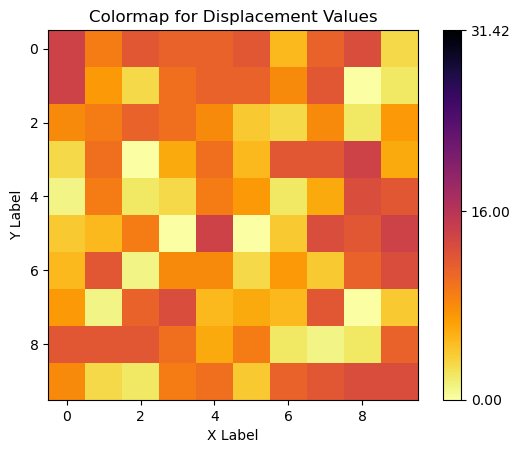

In [16]:
visualization.visualize_point_clouds_open3d(source_points, new_source_points, clip_point_cloud=True, clip_value=21)
visualization.visualize_point_clouds_open3d(tumor_points, all_new_tumor_points[0], clip_point_cloud=False)

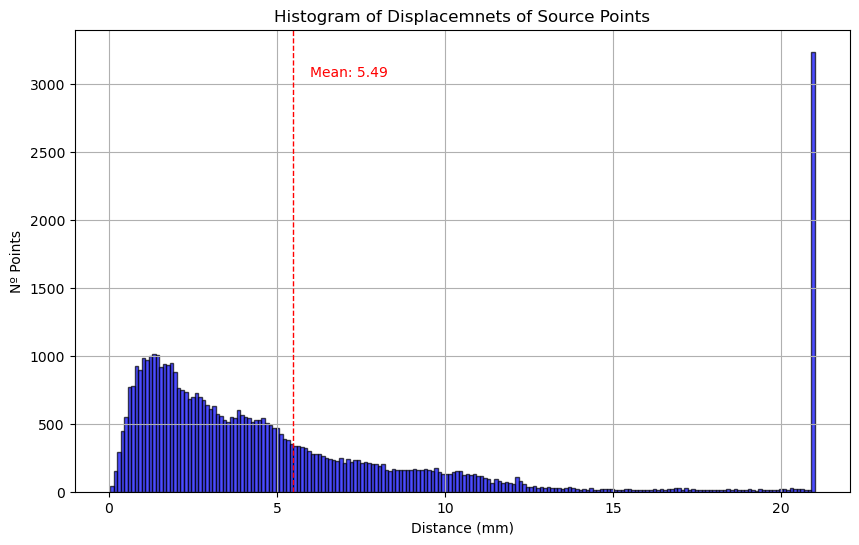

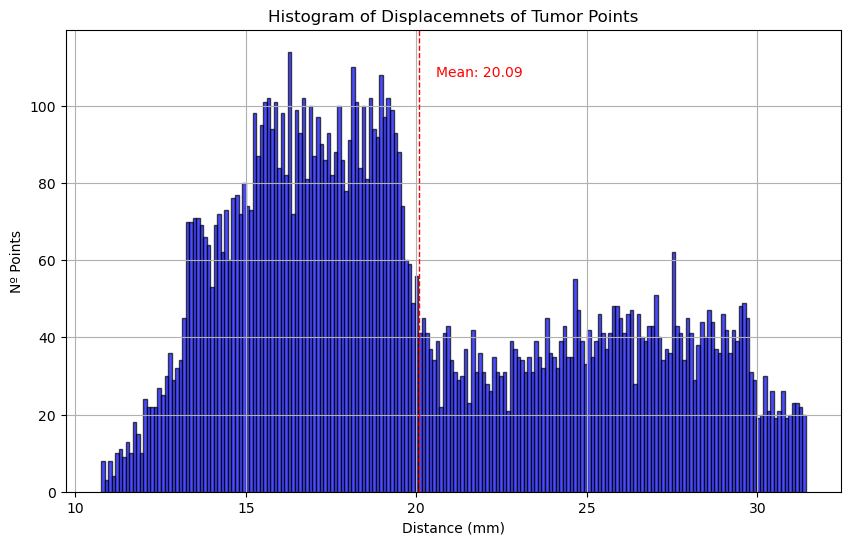

In [17]:
visualization.visualize_histogram_displacements(source_points, new_source_points, True, 21, "Source")
visualization.visualize_histogram_displacements(tumor_points, all_new_tumor_points[0], clip_point_cloud=False, point_cloud_name="Tumor")